# Treble in the Sheets Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Microsoft Research in Cambridge (MSRC) image understanding v2 dataset.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) David FOUHEY, #12345678

## Setup
First, we will install some required packages for this notebook and download the MSRC-v2 Image dataset. 


In [2]:
# install required packages and download the dataset
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install colormap easydev pypng torchsummary

In [3]:
import os
import time
import json
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed will be slowed down")
    device = 'cpu'

Using the CPU. Overall speed will be slowed down


## Dataset
We will create a custom Dataset function for the MSRC-v2 dataset. You don't have to change anything here.

In [5]:
N_CLASS = 5

class DeepScoresDataset(Dataset):
    def __init__(self, split, 
                 split_path="ds2_dense/split.json",
                 one_hot=False):
        super().__init__()
        self.one_hot = one_hot
        img_folder = 'ds2_dense/Images'
        mask_folder = 'ds2_dense/GroundTruth'
        GTQ_folder = 'ds2_dense/GT_Quantize'
        
        self.dataset = json.load(open(split_path, 'r'))[split]
        
        self.group2label_idx = {'void': 0, 'lineNote': 1, 'quarterRest': 2, 'clef': 3, 'middleNote': 4}
        
        self.img_list = [data[0] for data in self.dataset] #These are file names
        self.mask_list = [data[1] for data in self.dataset] #These are file names
        GTQ_list = [data[2] for data in self.dataset] #These are file names
        self.imgs = [np.array(Image.open(os.path.join(img_folder, img))) 
                     for img in self.img_list]
        self.masks = [np.array(Image.open(os.path.join(mask_folder, mask))) 
                      for mask in self.mask_list]
        self.q_masks = [np.load(os.path.join(GTQ_folder, gtq))
                        for gtq in GTQ_list]
            
        self.transform = transforms.Compose([
            transforms.Resize((848, 600))
        ])

    @staticmethod
    def rgb2str(rgb): return f"{rgb[0]},{rgb[1]},{rgb[2]}"

    @staticmethod
    def str2rgb(string): return [int(v) for v in string.split(',')]
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img = torch.FloatTensor(self.imgs[idx]).permute(2, 0, 1)
        qmask = torch.LongTensor(self.q_masks[idx])[None, :, :]
        qmask = qmask.squeeze()
        if self.one_hot:
            H, W = qmask.shape
            qmask = torch.nn.functional.one_hot(qmask.reshape(-1), len(self.group2label_idx)).reshape(H, W, -1)
            qmask = qmask.permute(2, 0, 1)
            assert torch.max(qmask) == 1
        
#         # Resize
#         resize = transforms.Resize(size=(img.shape[0]/2, img.shape[1]/2))
#         img = resize(img)
#         qmask = resize(mask)
        
        for i in range(10): # Try to get a rest 10 times
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(
                img, output_size=(256, 512))
            img = transforms.functional.crop(img, i, j, h, w)
            qmask = transforms.functional.crop(qmask, i, j, h, w)
            
            if (2 in qmask):
                break
        
        
        return img, qmask

## Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        ########################################################################
        # TODO: Implement a sematic segmentation model                         #
        ########################################################################
        self.sampling_factor = 2
        
        self.relu = nn.ReLU()
        
        #First Block (Downsampling 1)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(self.sampling_factor)
        
        #Second Block (Downsampling 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.maxpool2 = nn.MaxPool2d(self.sampling_factor)
        
        #Center Convolution
        self.convMiddle = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        
        #Third block (Upsampling 1)
        self.upsample1 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1, stride=1)
        
        #Fourth block (upsampling 2)
        self.upsample2 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv7 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.conv8 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        
        self.conv9 = nn.Conv2d(32, self.n_class, 3, padding=1, stride=1)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.convMiddle(x)
        x = self.relu(x)
        
        x = self.upsample1(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        
        x = self.conv9(x)
        
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return x

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [7]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,512,256), device=device)

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 256]             896
              ReLU-2         [-1, 32, 512, 256]               0
            Conv2d-3         [-1, 32, 512, 256]           9,248
              ReLU-4         [-1, 32, 512, 256]               0
         MaxPool2d-5         [-1, 32, 256, 128]               0
            Conv2d-6         [-1, 64, 256, 128]          18,496
              ReLU-7         [-1, 64, 256, 128]               0
            Conv2d-8         [-1, 64, 256, 128]          36,928
              ReLU-9         [-1, 64, 256, 128]               0
        MaxPool2d-10          [-1, 64, 128, 64]               0
           Conv2d-11          [-1, 64, 128, 64]          36,928
             ReLU-12          [-1, 64, 128, 64]               0
         Upsample-13         [-1, 64, 256, 128]               0
           Conv2d-14     

Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

In [8]:
def save_label(label, path, ):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#0080FF',
        '#000000',
        '#80FF80',
        '#FF8000',
        '#AA8000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    cnt = 0
    net = net.train()
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        cnt += 1
    end = time.time()
    running_loss /= cnt
    print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
    return running_loss

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print('\n',losses / cnt)
    return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(N_CLASS)]
        heatmaps = [[] for _ in range(N_CLASS)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(N_CLASS):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(N_CLASS):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))
        print("Average Precision (all classes) = {}".format(np.mean(aps)))
    return None


def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    os.makedirs(folder, exist_ok=True)
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            print(images.shape)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.argmax(output, 0).astype('uint8')
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave('./{}/x{}.png'.format(folder, cnt),
                     images[0].cpu().data.numpy().astype(np.uint8).transpose(1,2,0))
            cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure(figsize=(12, 8))
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('part3_training_hist.png', dpi=300)
    plt.show()

Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.65 all classes AP** on the test set. We also encourage to try to get a higher AP by improving your model design.

On normal Intel core CPU configuration, a valid model design that meets this requirement takes no longer than **10 minutes** to train. The same model take no more than **5 mintues** to finish the code below on Colab. You may use this as a reference when designing your own model. A network that is too deep/too large is not encouraged considering the size of the dataset.

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

HEre
HEre
HEre
HEre


  0%|          | 0/64 [00:00<?, ?it/s]


Start training
-----------------Epoch = 1-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 1] loss: 0.106 elapsed time 116.853
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.02819102376815863
-----------------Epoch = 2-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 2] loss: 0.018 elapsed time 118.267
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.02299704111101164
-----------------Epoch = 3-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 3] loss: 0.016 elapsed time 119.888
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.017465366730903042
-----------------Epoch = 4-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 4] loss: 0.017 elapsed time 117.168
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.016672383076638653
-----------------Epoch = 5-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 5] loss: 0.015 elapsed time 118.301
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.013512313148112298
-----------------Epoch = 6-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 6] loss: 0.013 elapsed time 118.140
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.014295330562788422
-----------------Epoch = 7-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 7] loss: 0.015 elapsed time 118.327
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.015067199665281805
-----------------Epoch = 8-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 8] loss: 0.012 elapsed time 119.794
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.013866626672097482
-----------------Epoch = 9-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 9] loss: 0.013 elapsed time 119.024
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.011087087924721573
-----------------Epoch = 10-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 10] loss: 0.013 elapsed time 117.458
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.011564069427549839
-----------------Epoch = 11-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 11] loss: 0.013 elapsed time 118.569
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.011148744487627482
-----------------Epoch = 12-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 12] loss: 0.010 elapsed time 118.227
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.012769665350788273
-----------------Epoch = 13-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 13] loss: 0.013 elapsed time 118.260
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.014149344264296815
-----------------Epoch = 14-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 14] loss: 0.013 elapsed time 117.953
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.014308600373624358
-----------------Epoch = 15-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 15] loss: 0.011 elapsed time 118.003
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.009743745293235406
-----------------Epoch = 16-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 16] loss: 0.009 elapsed time 117.603
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.005700534146683367
-----------------Epoch = 17-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 17] loss: 0.008 elapsed time 118.057
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.008498845578287728
-----------------Epoch = 18-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 18] loss: 0.008 elapsed time 117.075
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.006647142825386254
-----------------Epoch = 19-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 19] loss: 0.006 elapsed time 117.858
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0038589994493349877
-----------------Epoch = 20-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 20] loss: 0.008 elapsed time 117.647
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.005499423697202133
-----------------Epoch = 21-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 21] loss: 0.006 elapsed time 117.564
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.004876557763736855
-----------------Epoch = 22-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 22] loss: 0.006 elapsed time 119.206
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.004114467719773529
-----------------Epoch = 23-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 23] loss: 0.006 elapsed time 117.431
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.006057535710056072
-----------------Epoch = 24-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 24] loss: 0.005 elapsed time 117.993
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0026931664809808353
-----------------Epoch = 25-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 25] loss: 0.005 elapsed time 117.457
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.007408678175124805
-----------------Epoch = 26-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 26] loss: 0.005 elapsed time 117.721
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0032867819791135844
-----------------Epoch = 27-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 27] loss: 0.004 elapsed time 117.345
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.005583413742515475
-----------------Epoch = 28-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 28] loss: 0.005 elapsed time 2412.643
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.003948066297503772
-----------------Epoch = 29-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 29] loss: 0.003 elapsed time 6442.751
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.002801095525569508
-----------------Epoch = 30-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 30] loss: 0.004 elapsed time 121.432
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0025322396231786115
-----------------Epoch = 31-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 31] loss: 0.004 elapsed time 121.849
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0028248532694234996
-----------------Epoch = 32-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 32] loss: 0.003 elapsed time 27348.651
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0037792633306708012
-----------------Epoch = 33-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 33] loss: 0.004 elapsed time 2234.847
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.004282219422520939
-----------------Epoch = 34-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 34] loss: 0.004 elapsed time 140.261
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.004020831345087572
-----------------Epoch = 35-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 35] loss: 0.004 elapsed time 138.627
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.003617148737248499
-----------------Epoch = 36-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 36] loss: 0.004 elapsed time 142.895
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0037196236871750443
-----------------Epoch = 37-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 37] loss: 0.004 elapsed time 137.854
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.003977705004217569
-----------------Epoch = 38-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 38] loss: 0.006 elapsed time 140.875
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.00415371604685788
-----------------Epoch = 39-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 39] loss: 0.003 elapsed time 138.757
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0026038453864600797
-----------------Epoch = 40-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 40] loss: 0.002 elapsed time 143.179
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0033569804054423003
-----------------Epoch = 41-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 41] loss: 0.003 elapsed time 138.071
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0027559197042137384
-----------------Epoch = 42-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 42] loss: 0.003 elapsed time 139.589
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0038230703703447944
-----------------Epoch = 43-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 43] loss: 0.006 elapsed time 157.957
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0033230155236765313
-----------------Epoch = 44-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 44] loss: 0.004 elapsed time 161.891
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0033583946394344366
-----------------Epoch = 45-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 45] loss: 0.003 elapsed time 168.602
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0033626126331824935
-----------------Epoch = 46-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 46] loss: 0.003 elapsed time 161.973
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0029231394186979287
-----------------Epoch = 47-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 47] loss: 0.003 elapsed time 162.568
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0029136028518905732
-----------------Epoch = 48-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 48] loss: 0.002 elapsed time 161.067
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.002645845615781184
-----------------Epoch = 49-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 49] loss: 0.002 elapsed time 162.457
Validation loss: 


  0%|          | 0/64 [00:00<?, ?it/s]


 0.0026007053320427076
-----------------Epoch = 50-----------------


  0%|          | 0/16 [00:00<?, ?it/s]


 [epoch 50] loss: 0.002 elapsed time 164.906
Validation loss: 


100%|██████████| 16/16 [00:16<00:00,  1.03s/it]



 0.0029037773308715487


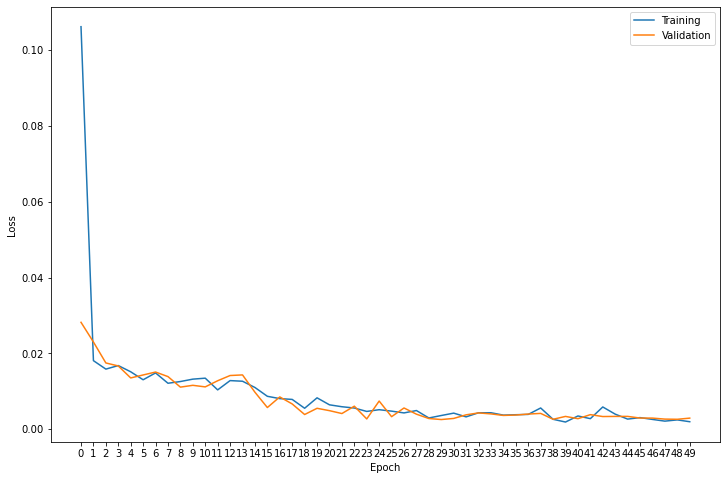

  0%|          | 0/40 [00:00<?, ?it/s]


Finished Training, Testing on test set


  0%|          | 0/40 [00:00<?, ?it/s]


 0.0018452419858661529

Generating Unlabeled Result


  0%|          | 0/40 [00:00<?, ?it/s]

Here


100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


AP = 0.9999906021779864
AP = 0.9963796976827055
AP = 0.9635665525979011
AP = 0.5614235538620217
AP = 0.9962068355961257
Average Precision (all classes) = 0.9035134483833481
CPU times: user 1h 55min 31s, sys: 49min 6s, total: 2h 44min 37s
Wall time: 12h 34min 39s


In [9]:
%%time
# Set up the random seed for reproducibility, you should not modify the seed used here
torch.manual_seed(442)
random.seed(442)
np.random.seed(442)

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
#criterion = DiceLoss()

# Define the dataset and dataloder
print("HEre")
train_data = DeepScoresDataset("train")
print("HEre")
val_data = DeepScoresDataset("validation")
print("HEre")
test_data = DeepScoresDataset("test")
print("HEre")

train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = DeepScoresDataset("test", one_hot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

learning_rate = 0.001
weight_decay = 0#1e-5
num_epoch = 50  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

print('\nStart training')
trn_hist = []
val_hist = []
net.train()
for epoch in range(num_epoch): #TODO: Change the number of epochs
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
    print('Validation loss: ')
    val_loss = test(val_loader, net, criterion, device)
    trn_hist.append(trn_loss)
    val_hist.append(val_loss)

net.eval()
plot_hist(trn_hist, val_hist)

print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')

result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_skiplink_{}.pth'.format(name))
print("Here")
cal_AP(ap_loader, net, criterion, device)

image: 13


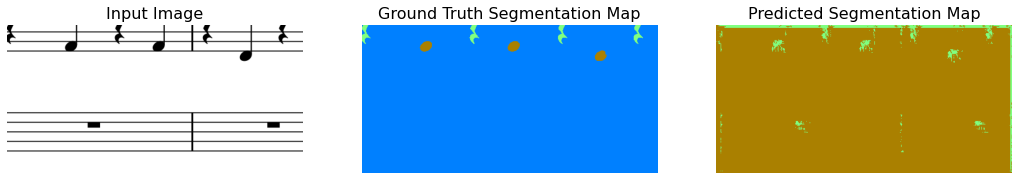

In [10]:
img_idx = 13

print(f'image: {img_idx}')
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

# Full Page Combiner

In [12]:
import math
import cv2

## Load the NET
net = Net().to(device)
net.load_state_dict(torch.load("./models/model_skiplink_starter_net_12hrs.pth"))
net.eval()

# Get Image with some padding
img_name = 'lg-5987734-aug-gutenberg1939--page-12.png'
img = np.array(Image.open(os.path.join('ds2_dense/Images', img_name)))
cv2.imwrite(os.path.join('output', img_name), img)
H, W, _ = img.shape

img_w_padding = array_created = np.full((H + 256, W+512, 3), 255, dtype = np.uint8)
img_w_padding[0:H, 0:W] = img
img = img_w_padding
segmented_img = np.zeros(img.shape)
img = torch.FloatTensor(img).permute(2, 0, 1)


##### Segment the image a bunch of times
for row in range(math.ceil(H/256)):
    for col in range(math.ceil(W/512)):
        print(row, col)
        i = row * 256
        j = col*512
        h = 256
        w = 512
        

        cropped_img = transforms.functional.crop(img, i, j, h, w)
        cropped_img = cropped_img.unsqueeze(0)

        folder = "output"

        os.makedirs(folder, exist_ok=True)
        with torch.no_grad():
            output = net(cropped_img)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.argmax(output, 0).astype('uint8')
            save_label(y, './{}/{},{}.png'.format(folder, row, col))
print("Finished Making All the Images!")

##### Put the images back together
for row in range(math.ceil(H/256)):
    for col in range(math.ceil(W/512)):
        f_name = str(row) + "," + str(col) + ".png"
        segmented_segment = cv2.imread(os.path.join('output', f_name), cv2.IMREAD_COLOR)
        i = row * 256
        j = col*512
        segmented_img[i:i+256, j:j+512] = segmented_segment

segmented_img = segmented_img[0:H, 0:W]
cv2.imwrite('output/final.png', segmented_img)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
8 0
8 1
8 2
8 3
9 0
9 1
9 2
9 3
10 0
10 1
10 2
10 3
Finished Making All the Images!


True